In [32]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Carregar os dados

In [33]:
df = pd.read_pickle("..//datasets/processed/laptop_price.pkl")
df.head()

,company,typename,inches,x_screen,y_screen,cpu_manufacturer,cpu_ghz,gpu_manufacturer,ram_gb,memory_0_gb,memory_0_type,memory_1_gb,memory_1_type,opsys,weight_kg,price_euros
0,Apple,Ultrabook,13.3,2560,1600,Intel,2.3,Intel,8,128,ssd,0,0,macOS,1.37,1339.69
1,Apple,Ultrabook,13.3,1440,900,Intel,1.8,Intel,8,128,flash storage,0,0,macOS,1.34,898.94
2,HP,Notebook,15.6,1920,1080,Intel,2.5,Intel,8,256,ssd,0,0,Outros,1.86,575.00
3,Apple,Ultrabook,15.4,2880,1800,Intel,2.7,AMD,16,512,ssd,0,0,macOS,1.83,2537.45
4,Apple,Ultrabook,13.3,2560,1600,Intel,3.1,Intel,8,256,ssd,0,0,macOS,1.37,1803.60


In [34]:
features = df.drop(columns='price_euros')
for item in ['company', 'typename', 'cpu_manufacturer', 'gpu_manufacturer', 'memory_0_type', 'memory_1_type', 'opsys']:
    features[item] = LabelEncoder().fit_transform(features[item])
target = df.price_euros

train_x, test_x, train_y, test_y = train_test_split(features, target, test_size=0.3)

## Models

In [35]:
models = {
    'Random Forest Regressor': RandomForestRegressor(),
    'KNeighbors Regressor': KNeighborsRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Linear Regression': LinearRegression()
}

for name, model_ in models.items():
    model = model_
    model.fit(train_x, train_y)
    pred_y = model.predict(test_x)
    print(f'Algorithm: {name}',)
    print(f'R2 score: {r2_score(test_y,pred_y):.02f}',)
    print('Mean Absolute Error:', mean_absolute_error(test_y,pred_y))
    print('********************************************************')

Algorithm: Random Forest Regressor
R2 score: 0.83
Mean Absolute Error: 182.9616083235903
********************************************************
Algorithm: KNeighbors Regressor
R2 score: 0.69
Mean Absolute Error: 241.17851662404092
********************************************************
Algorithm: Decision Tree Regressor
R2 score: 0.71
Mean Absolute Error: 229.65398976982098
********************************************************
Algorithm: Linear Regression
R2 score: 0.68
Mean Absolute Error: 274.52468118228546
********************************************************


## Best Params

In [36]:
models = {
    'Random Forest Regressor': RandomForestRegressor(bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100),
    'KNeighbors Regressor': KNeighborsRegressor(n_neighbors=3),
    'Decision Tree Regressor': DecisionTreeRegressor(max_depth= 12, max_features= 'sqrt', max_leaf_nodes= 90, min_samples_leaf= 1, splitter= 'best'),
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, positive=False)
}

for name, model_ in models.items():
    model = model_
    model.fit(train_x, train_y)
    pred_y = model.predict(test_x)
    print(f'Algorithm: {name}',)
    print(f'R2 score: {r2_score(test_y,pred_y):.02f}',)
    print('Mean Absolute Error:', mean_absolute_error(test_y,pred_y))
    print('********************************************************')

Algorithm: Random Forest Regressor
R2 score: 0.81
Mean Absolute Error: 190.1595758781783
********************************************************
Algorithm: KNeighbors Regressor
R2 score: 0.67
Mean Absolute Error: 233.43865302642797
********************************************************
Algorithm: Decision Tree Regressor
R2 score: 0.65
Mean Absolute Error: 258.81471034544825
********************************************************
Algorithm: Linear Regression
R2 score: 0.68
Mean Absolute Error: 276.0356860900953
********************************************************


## Random Forest Regression

In [37]:
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }
# grid = GridSearchCV(RandomForestRegressor(), param_grid)
# grid.fit(train_x, train_y)
# grid.best_params_

## KNeighbors Regression

In [38]:
# param_grid = dict(n_neighbors=np.arange(1, 100))
# grid = GridSearchCV(KNeighborsRegressor(), param_grid)
# grid.fit(train_x, train_y)
# grid.best_params_

## Decision Tree Regression

In [39]:
# param_grid={"splitter":["best","random"],
#            "max_depth" : [1,3,5,7,9,11,12],
#            "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
#            "max_features":["log2","sqrt"],
#            "max_leaf_nodes":[10,20,30,40,50,60,70,80,90]
# }

# grid = GridSearchCV(DecisionTreeRegressor(), param_grid)
# grid.fit(train_x, train_y)
# grid.best_params_

## Linear Regression

In [40]:
# param_grid = {
#     'copy_X': [True, False],
#     'fit_intercept': [True, False],
#     'n_jobs': np.arange(1, 100),
#     'positive': [True, False]
# }

# grid = GridSearchCV(LinearRegression(), param_grid)
# grid.fit(train_x, train_y)
# grid.best_params_

## Experiments

In [41]:
def experiment(model, features, target, n_splits=5):
    kf = KFold(n_splits=n_splits)

    scores = dict(
        train_count = list(),
        train_true_percent = list(),
        train_scores = list(),
        valid_count = list(),
        valid_true_percent = list(),
        valid_scores = list()
    )
    

    for train_index, valid_index in kf.split(features):
        train_x, train_y = features.iloc[train_index], target.iloc[train_index]
        valid_x, valid_y = features.iloc[valid_index], target.iloc[valid_index]
        
        model.fit(train_x, train_y)

        fold_train_score = r2_score(train_y, model.predict(train_x))
        fold_valid_score = r2_score(valid_y, model.predict(valid_x))

        scores['train_count'].append(train_x.shape[0])
        scores['valid_count'].append(valid_x.shape[0])
        scores['train_true_percent'].append(train_y.sum() / train_y.shape[0])
        scores['valid_true_percent'].append(valid_y.sum() / valid_y.shape[0])

        scores['train_scores'].append(fold_train_score)
        scores['valid_scores'].append(fold_valid_score)
    
    return pd.DataFrame(scores)

def plot_validation_curve(results, title, ax):
    x = np.arange(results.shape[0])

    ax.plot(x, results.train_scores, 'o-', label='Training Score')
    ax.plot(x, results.valid_scores, 'o-', label='Validation Score')

    ax.set_title(title)
    ax.set_ylim(.65, 1)
    ax.legend()
    ax.grid()

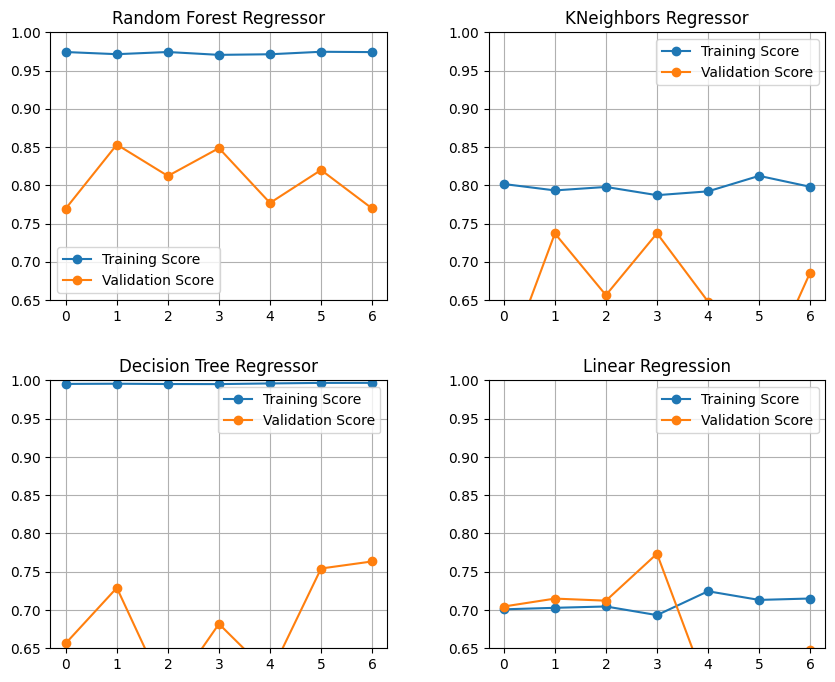

In [42]:
models = {
    'Random Forest Regressor': RandomForestRegressor(),
    'KNeighbors Regressor': KNeighborsRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Linear Regression': LinearRegression()
}

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

model_results = list()
for ax, (model_name, model) in zip([ax1, ax2, ax3, ax4], models.items()):
    results = experiment(model, features, target, n_splits=7)
    results['model'] = model_name
    model_results.append(results)

    plot_validation_curve(results, model_name, ax)
model_results = pd.concat(model_results, axis=0)

plt.subplots_adjust(wspace=.3, hspace=.3)
plt.show()

In [43]:
model_results.groupby('model', as_index=False).agg({
    'train_scores': ['mean', 'std', 'min', 'max'],
    'valid_scores': ['mean', 'std', 'min', 'max']
}).round(3)

model train_scores                      valid_scores  \
                                   mean    std    min    max         mean   
0  Decision Tree Regressor        0.996  0.001  0.995  0.997        0.684   
1     KNeighbors Regressor        0.798  0.008  0.787  0.812        0.651   
2        Linear Regression        0.708  0.010  0.693  0.725        0.683   
3  Random Forest Regressor        0.973  0.002  0.970  0.975        0.807   

                        
     std    min    max  
0  0.069  0.585  0.763  
1  0.079  0.537  0.737  
2  0.061  0.595  0.774  
3  0.036  0.770  0.853

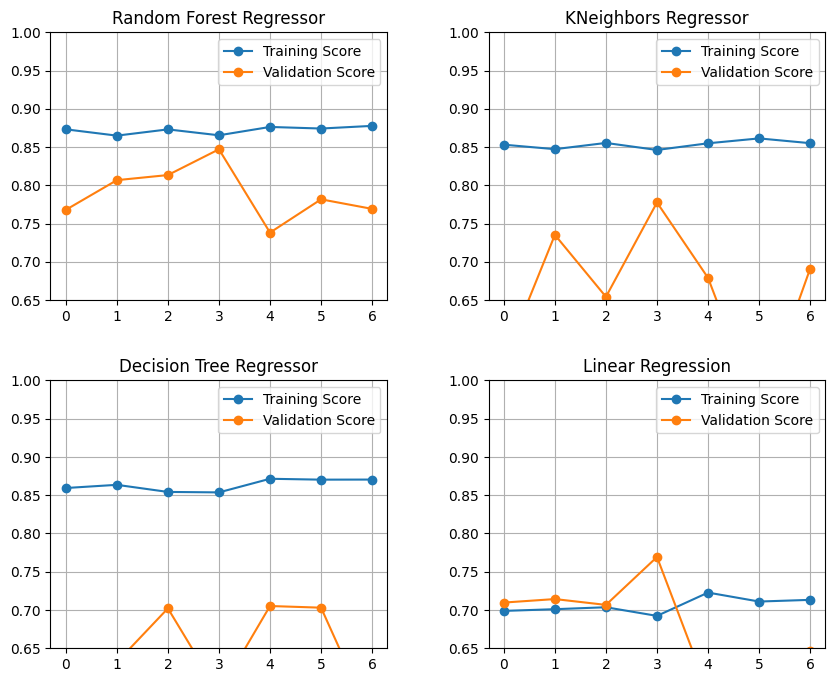

In [44]:
models = {
    'Random Forest Regressor': RandomForestRegressor(bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100),
    'KNeighbors Regressor': KNeighborsRegressor(n_neighbors=3),
    'Decision Tree Regressor': DecisionTreeRegressor(max_depth= 12, max_features= 'sqrt', max_leaf_nodes= 90, min_samples_leaf= 1, splitter= 'best'),
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, positive=False)
}

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

model_results = list()
for ax, (model_name, model) in zip([ax1, ax2, ax3, ax4], models.items()):
    results = experiment(model, features, target, n_splits=7)
    results['model'] = model_name
    model_results.append(results)

    plot_validation_curve(results, model_name, ax)
model_results = pd.concat(model_results, axis=0)

plt.subplots_adjust(wspace=.3, hspace=.3)
plt.show()

In [45]:
model_results.groupby('model', as_index=False).agg({
    'train_scores': ['mean', 'std', 'min', 'max'],
    'valid_scores': ['mean', 'std', 'min', 'max']
}).round(3)

model train_scores                      valid_scores  \
                                   mean    std    min    max         mean   
0  Decision Tree Regressor        0.863  0.008  0.854  0.872        0.626   
1     KNeighbors Regressor        0.853  0.005  0.846  0.861        0.659   
2        Linear Regression        0.706  0.010  0.692  0.723        0.682   
3  Random Forest Regressor        0.872  0.005  0.865  0.878        0.789   

                        
     std    min    max  
0  0.084  0.491  0.705  
1  0.094  0.504  0.778  
2  0.060  0.594  0.769  
3  0.036  0.738  0.847